In [407]:
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt

# This code solves the moist energy balance model (MEBM) used in Roe et al. (Nat. Geosci., 2015)
# It also includes the Hadley Cell parameterization used in Siler et al. (Journal of Climate 2018) to route tropical moisture in the correct direction
# It predicts moisture convergence, and thus evaporation minus precipitatation (E-P), from which P is calculated with a simple representation of E
# The model operates in perturbation mode (i.e., the anomaly with respect to a prescribed climatology):
# You can specify:-
# the pattern of climate forcing (Rf)
# the pattern of climate feedbacks (feedback)
# the ocean heat uptake (G)
# the diffusivity (D)
# whether you diffuse moist static energy, or just sensible heat

In [408]:
#time step in fraction of year
delt=1./50000;
NMAX=1000000; #maximum number of timesteps

#set up grid for model (x = sine of latitude).
jmx=101; #number of grid points
delx = 2.0/jmx;
x = np.arange(-1.0+delx/2,1.0,delx) #grid points
phi = np.arcsin(x)*180/np.pi; #latitude at each grid point

# C = rho * c * h_ml /(pi*1e7).
Cl = 0.2; # heat capacity, units: J /(m2 K) consistent with 1 meter of dirt (low heat capacitity for fast convergence)

In [409]:
# Moisture parameters
relhum = 0.8;   # relative humidity
eps = 0.622;    # moisture coonstant
psfc = 9.8e4;   # (Pa)
e0 = 611.2;     # vap. press (Pa)
a = 17.67; b = 243.5;   # sat vap constants !!T must be in Celcius
L = 2.45e6;         # latent heat of vaporization (J kg-1)
cp = 1004;          # (J kg-1 K-1)

In [410]:
# magnitude of diffusivity
Dmag = 0.2598; # D = 0.2598 W/(m2 K) is the value used by TF10 
D=Dmag*np.ones(jmx+1); # diffusivity for MSE

In [411]:
# For dry energy balance model, uncomment these lines: (Parts D and E of HW3)
#Dmag = 0.44; # magnitude of diffusivity [W/(m2 K)]
#D=Dmag*np.ones(jmx+1); # diffusivity for sensible (cp*T)
#relhum = 0;  # switch off humidity

In [412]:
#load in the climatological temperature from ERA-Interim for the control climate
matLabData = io.loadmat('ERAtemperature.mat') #loads matlab file as a dictionary with some metadata
#matLabData.keys() #tell me what's in the dictionary
lat = np.asarray(matLabData['lat'])
T_ctrl = np.asarray(matLabData['T'])
# uncomment this line to symmetrize the assumed climatological temperature
# T_ctrl = 0.5*(T_ctrl+np.flipud(T_ctrl)); # average N & S hemispheres for symmetry
T_ctrl.shape
from scipy.interpolate import griddata
T_ctrl = griddata(np.sin(np.deg2rad(lat)), T_ctrl, x, method='linear') #interp1(sind(lat),T_ctrl,x,'linear');
T_ctrl = np.squeeze(T_ctrl, axis=1)
q_ctrl = eps*relhum/psfc*e0*np.exp(a*(T_ctrl)/(b+(T_ctrl)));  #q=q(:); # here T is in oC. q is g kg-1
theta_e_ctrl = 1/cp*(cp*((T_ctrl)+273.15) + L*q_ctrl); #theta is mse divided by cp. note units of Kelvin are needed!!!

In [413]:
#--------------------------------------------------------------
# Choose a pattern of feedbacks, forcing, and ocean heat uptake. (PARTS A, B, C, D of HW3)
# Default is CMIP5-mean pattern, but you can use individual feedbacks or uniform feedback and forcing by uncommenting lines below

#CMIP5 ensemble-mean feedback and forcing values from 4xCO2 simulations (taken at year 100)
matLabData = io.loadmat('CMIP5_Rf_lambda_G.mat') #feedback, forcing, and heat uptake 
CMIP5_lat = np.asarray(matLabData['lat']) #latitude
feedback = np.squeeze(griddata(CMIP5_lat,np.asarray(matLabData['lambda_total']),phi, method='linear')) #Radiative feedback
Rf = np.squeeze(griddata(CMIP5_lat,np.asarray(matLabData['Rf']),phi, method='linear')) #Radiative forcing
G = np.squeeze(griddata(CMIP5_lat,np.asarray(matLabData['G']),phi, method='linear')) #Ocean heat uptake

# G = 0*np.ones(x.size) # uncomment to set ocean heat uptake to zero (Part C of HW3)
R_frc = Rf + G #CO2 forcing (Rf) with ocean heat uptake (G)


# part g
print(np.where(phi>=-30)[0])  # find it
print(np.where(phi<=30)[0]) 
print(phi[25]) # double check it
print(phi[75])

# actually modify: 
#print(feedback[25:75])
#feedback[25:75] = feedback[25:75] + 0.1
#print(feedback[25:75])

#feedback[:25] = feedback[:25] + 0.1
#feedback[75:] = feedback[75:] + 0.1



[ 25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42
  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75]
-29.673014802474018
29.67301480247414


In [414]:
# For uniform forcing, uniform feedbacks, no ocean heat uptake, uncomment all of these lines: (Part E of HW3)
#feedback = -1.45*np.ones(x.size) # uniform feedback [W/m2/K], 1.45 W/m2 value taken as average of CMIP5 feedback
#Rf = 7.8*np.ones(x.size) # uniform forcing in [W/m2] for a quadrupling of CO2, 7.8 value taken as global average of CMIP5 forcing
#G = 0*np.ones(x.size) # set ocean heat uptake to zero
#R_frc = Rf + G #CO2 forcing (Rf) plus ocean heat uptake (G)
#print('Using uniform forcing and feedbacks instead of CMIP5!!')

In [415]:
# For using individual feedbacks, uniform CO2 forcing, and no ocean heat uptake, uncomment these: (Part F of HW3)
#print('Using flat forcing and one feedback at a time instead of CMIP5!!')
#Rf = 7.8*np.ones(x.size) # uniform forcing in [W/m2] for a quadrupling of CO2, 7.8 value taken as global average of CMIP5 forcing
#G = 0*np.ones(x.size) # set ocean heat uptake to zero
#R_frc = Rf + G; #CO2 forcing (Rf) plus ocean heat uptake (G)

#and uncomment ONE of these:
#feedback = np.squeeze(griddata(CMIP5_lat,np.asarray(matLabData['lambda_planck']),phi, method='linear')) #uncomment to use just the Planck feedback
#feedback = np.squeeze(griddata(CMIP5_lat,np.asarray(matLabData['lambda_planck'])+np.asarray(matLabData['lambda_lapserate']),phi, method='linear')) #uncomment to use just the lapse rate plus Planck feedback
#feedback = np.squeeze(griddata(CMIP5_lat,np.asarray(matLabData['lambda_planck'])+np.asarray(matLabData['lambda_watervapor']),phi, method='linear')) #uncomment to use just the water vapor plus Planck feedback
#feedback = np.squeeze(griddata(CMIP5_lat,np.asarray(matLabData['lambda_planck'])+np.asarray(matLabData['lambda_cloud']),phi, method='linear')) #uncomment to use just the cloud plus Planck feedback
#feedback = np.squeeze(griddata(CMIP5_lat,np.asarray(matLabData['lambda_planck'])+np.asarray(matLabData['lambda_albedo']),phi, method='linear')) #uncomment to use just the albedo plus Planck feedback

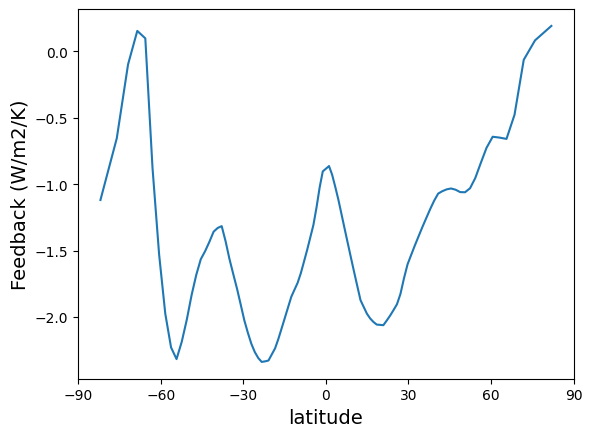

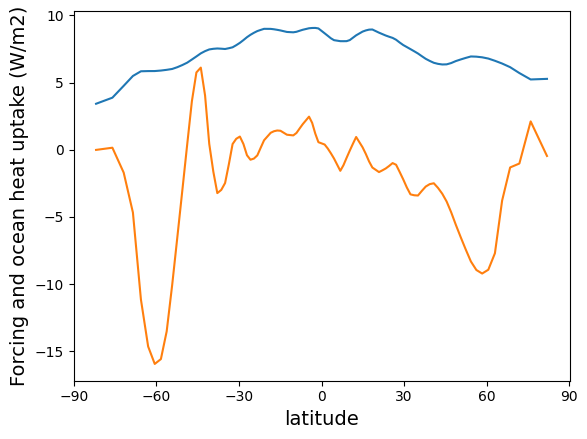

In [416]:
#plot net feedback, forcing, and ocean heat uptake you're using
plt.plot(phi,feedback)
plt.xticks(np.arange(-90, 91, 30))
plt.xlabel('latitude', fontsize=14)
plt.ylabel('Feedback (W/m2/K)', fontsize=14)
plt.show()

plt.plot(phi,Rf)
plt.plot(phi,G)
plt.xticks(np.arange(-90, 91, 30))
plt.xlabel('latitude', fontsize=14)
plt.ylabel('Forcing and ocean heat uptake (W/m2)', fontsize=14)
plt.show()

In [417]:
#Create matrix to take a divergence of something it acts on   
#set up lambda array. Note: lambda is not feedback here.
lam=(1-np.square(np.arange(-1.0,1.0+delx,delx)))/np.square(delx);
lam=np.multiply(D, lam); 

M = np.zeros((jmx,jmx));

M[0,0] =  - lam[1];
M[0,1] = lam[1];

M[jmx-1,jmx-2] = lam[jmx-1];
M[jmx-1,jmx-1]   = - lam[jmx-1];

for j in range(1, jmx-1): 
  M[j,j-1] = lam[j]
  
  M[j,j]   = - (lam[j+1]+lam[j])
  
  M[j,j+1] = lam[j+1]


Mdiv = M; #Divergence matrix 

In [418]:
# Now solve climate change experiment
#set up inital T profile 
T = 0.5*(1-1*x*x)
Tinit=T;
Tglob = np.mean(Tinit)
#T.shape

In [419]:
# Timestepping loop. Note that it takes a couple mins to run this part
for j in range(0, NMAX-1):
   
   #print(np.mean(T)) 
   
    # spec. hum, and theta_e
   q = eps*relhum/psfc*e0*np.exp(a*(T+T_ctrl)/(b+(T+T_ctrl))); # here T is in oC. q is g kg-1
   
   theta_e = 1/cp*(cp*((T+T_ctrl)+273.15) + L*q); # note units of Kelvin are needed!!!
   
   theta_e_pert = theta_e-theta_e_ctrl; #anomalous theta_e
    
    # Calculate new T from Source and Sink terms.
    # Diffuse anomalous moist static energy (theta_e_pert)
   dT = delt/Cl*(R_frc + (feedback*T) + np.matmul(Mdiv,theta_e_pert));
   
   T = T + dT; 
    
   #print(np.mean(T))

  # Check to see if global mean energy budget has converged:   
   Fglob=np.mean(R_frc + (feedback*T))
    
   if np.absolute(Fglob) < 0.001: #if (abs(Fglob) < 0.001), break; end
        break  
print(Fglob) 

0.000999944474329241


In [420]:
print(np.mean(T)) #temperature anomaly -- note that with grid x=sin(lat) taking the mean is already area weighted! Yay!
divF_pert = -np.matmul(Mdiv,theta_e_pert);
h_pert = theta_e_pert*cp;

4.245338431888024


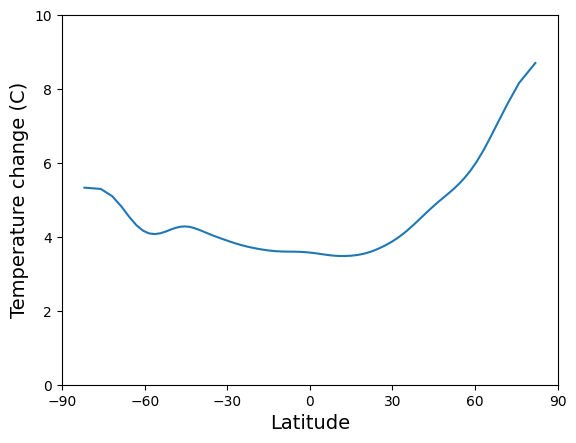

In [421]:
plt.plot(phi,T) #plot zonal mean temperature change
plt.xticks(np.arange(-90, 91, 30))
plt.yticks(np.arange(0, 11, 2))
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Temperature change (C)', fontsize=14)
plt.show()

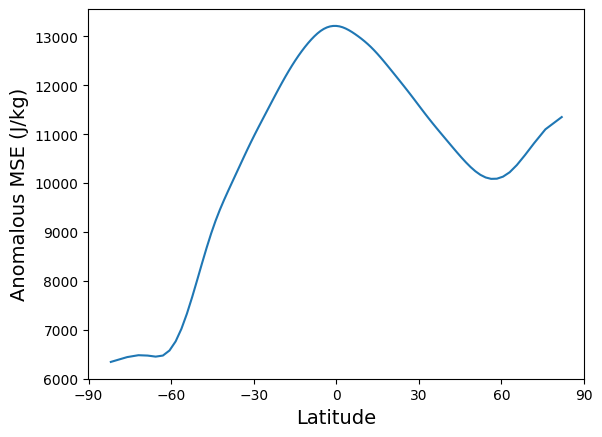

In [422]:
plt.plot(phi,h_pert) #plot MSE anomaly
plt.xticks(np.arange(-90, 91, 30))
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Anomalous MSE (J/kg)', fontsize=14)
plt.show()

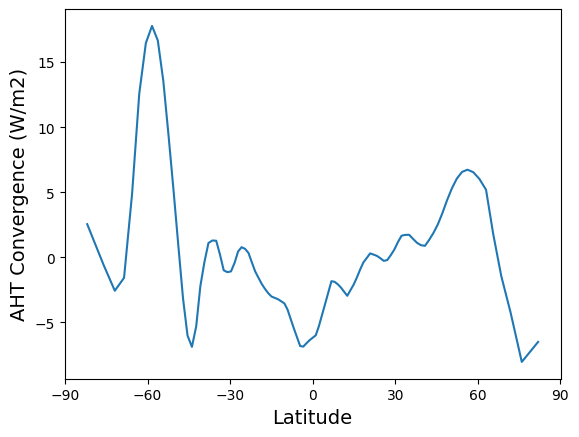

In [423]:
plt.plot(phi,-divF_pert) #plot anomalous AHT convergence 
plt.xticks(np.arange(-90, 91, 30))
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('AHT Convergence (W/m2)', fontsize=14)
plt.show()

In [424]:
# Module to calculate terms in hyrological cycle

q_expt = q
q_pert = q_expt-q_ctrl
divF_pert = -Mdiv*theta_e_pert
h_pert = theta_e_pert*cp
T_pert = T
T_expt = T+T_ctrl

# define some things from the climatology first 

Re = 6.4e6;                 # [m] earth's radius
rho = 1e3;                  # [kg m-3] density

import matplotlib.pyplot as plt
import numpy as np
#import matplotlib.mlab as mlab
import math

#wt = 1-mlab.normpdf(x, 0, np.sin(15*2*np.pi/360))/mlab.normpdf(0, 0, np.sin(15*2*np.pi/360)) # define Gaussian Hadley Cell width wt = 1-gaussmf(x,[sind(15) 0]);

from scipy.stats import norm
wt = 1-norm.pdf(x, 0, np.sin(15*2*np.pi/360))/norm.pdf(0, 0, np.sin(15*2*np.pi/360)) # define Gaussian Hadley Cell width wt = 1-gaussmf(x,[sind(15) 0]);


In [425]:
# calculate some things about the control climate (ctrl) prior to 4xCO2 perturbation

Dhlf = Dmag*np.ones(jmx)                                   # [W m-2 K-1] calculate D on same grid as T,q, etc ##0.5*(D(1:end-1)+D(2:end));  #WARNING: would need to modify this if allowing D to vary with latitude
h_ctrl = cp*(T_ctrl+273.15)+L*q_ctrl                       # [J kg-1] control climate mse
F_ctrl = -2*np.pi*np.square(Re)/cp*Dhlf*(1-np.square(x))*np.gradient(h_ctrl,x)  # [W] control climate flux 
F_lh_ctrl = -2*np.pi*np.square(Re)/cp*Dhlf*(1-np.square(x))*np.gradient(L*q_ctrl,x)    # [W] control latent heat flux
F_hc_ctrl = (1-wt)*F_ctrl                                 # [W] Hadley Cell Flux
heq_ctrl = h_ctrl[50]                                 #value at equator WARNING will have to change if change grid ; # [J kg-1] moist static energy at the surface
V_ctrl = F_hc_ctrl/(heq_ctrl*1.07-h_ctrl)               # [kg s-1] Diagnosed mass transport in Hadley Cell (Nick's way)

F_LH_ctrl = -L*V_ctrl*q_ctrl + wt*F_lh_ctrl              # [W] latent heat (Hadley plus eddy)
F_LH_eddy_ctrl = wt*F_lh_ctrl                         # eddy latent heat fluxes including weighting function.
divF_LH_ctrl = 1/(2*np.pi*np.square(Re))*np.gradient(F_LH_ctrl,x)         # [W m-2] divergence of latent heat flux
E_m_P_ctrl = divF_LH_ctrl/(L*rho)*np.pi*1e7                   # [m yr-1]E-P

# code from Nick Siler to partition E-P;
alpha=L/461.5/np.square(T_ctrl+273.15)                         # Nick's alpha parameter
beta=cp/L/alpha/q_ctrl                                   # beta parameter
RG=180*(1*(1-np.square(x))-.4*np.exp(-np.square((x/.15))))                   # [W m-2] idealized R-G
Ch=1.5e-3                                                  # drag coefficient
LWfb=0                                                     # LW feedback at surface, in W/m2/K
u=4+np.abs(np.sin(np.pi*x/1.5))*4; #-2.5*cos(3*np.arcsin(x))     # wind speed
rho_air=1.2       #psfc/287/(T_ctrl+273.15)               # air density
E_ctrl=(RG*alpha+rho_air*cp*(1-relhum)*Ch*u)/(alpha+cp/L/q_ctrl)
P_ctrl=E_ctrl-divF_LH_ctrl
#P_ctrl=P_ctrl/(L*rho)*np.pi*1e7 # [m yr-1]
#E_ctrl=E_ctrl/(L*rho)*np.pi*1e7 # [m yr-1]

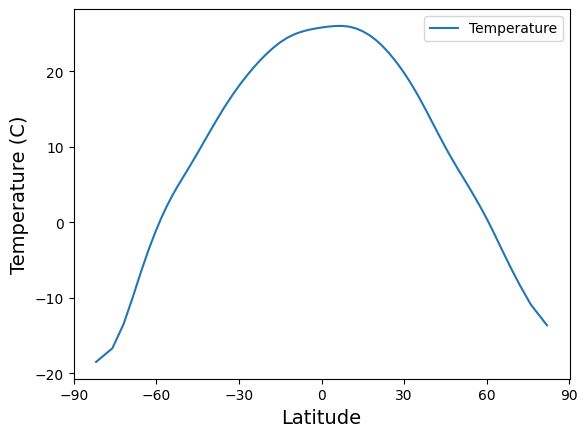

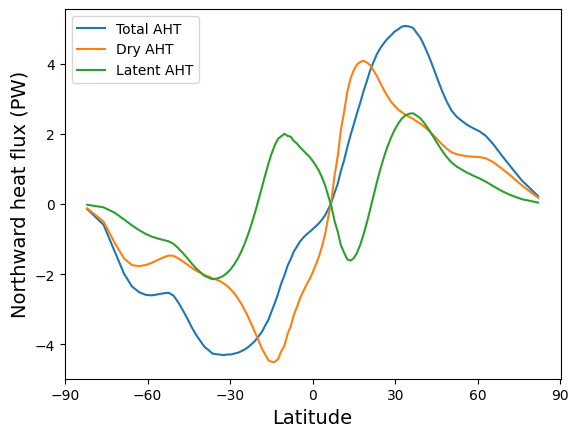

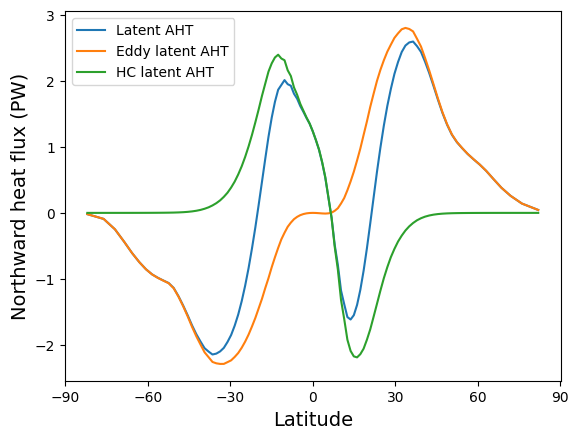

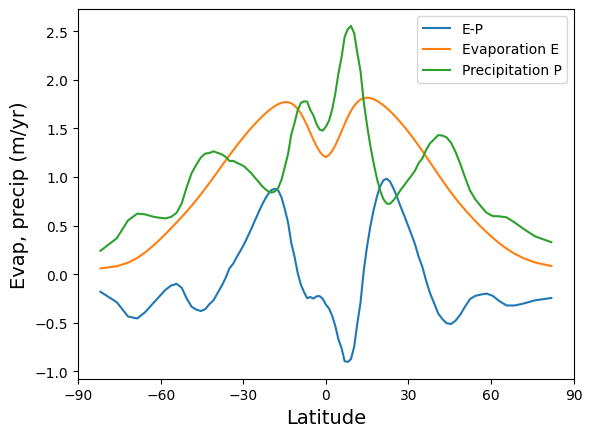

In [426]:
# Figures for climatology prior to 4xCO2 perturbation

plt.plot(phi,T_ctrl)
plt.legend(["Temperature"])
plt.xticks(np.arange(-90, 91, 30))
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Temperature (C)', fontsize=14)
plt.show()

plt.plot(phi,F_ctrl/10**15) #total heat transport
plt.plot(phi,(F_ctrl-F_LH_ctrl)/10**15) #dry
plt.plot(phi,F_LH_ctrl/10**15) #latent
plt.legend(["Total AHT", "Dry AHT", "Latent AHT"])
plt.xticks(np.arange(-90, 91, 30))
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Northward heat flux (PW)', fontsize=14)
plt.show()

plt.plot(phi,F_LH_ctrl/10**15) #latent heat transport
plt.plot(phi,F_LH_eddy_ctrl/10**15) #eddy component of latent
plt.plot(phi,-L*V_ctrl*q_ctrl/10**15) #Hadley cell component of latent 
plt.legend(["Latent AHT", "Eddy latent AHT", "HC latent AHT"])
plt.xticks(np.arange(-90, 91, 30))
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Northward heat flux (PW)', fontsize=14)
plt.show()

plt.plot(phi,E_m_P_ctrl) #Evaporation minus precipitation (E-P) in m/yr
plt.plot(phi,E_ctrl/(L*rho)*np.pi*1e7) #Evaporation in m/yr
plt.plot(phi,P_ctrl/(L*rho)*np.pi*1e7) #Precipitation in m/yr
plt.legend(["E-P", "Evaporation E", "Precipitation P"])
plt.xticks(np.arange(-90, 91, 30))
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Evap, precip (m/yr)', fontsize=14)
plt.show()

In [427]:
# calculate some things about the new climate state (expt) under 4xCO2 forcing

h_expt = h_ctrl+h_pert                                 # [J kg-1] new total mse
F_expt = -2*np.pi*np.square(Re)/cp*Dhlf*(1-np.square(x))*np.gradient(h_expt,x)      # [W] new total flux
F_lh_expt = -2*np.pi*np.square(Re)/cp*Dhlf*(1-np.square(x))*np.gradient(L*q_expt,x)    # [W] control latent heat flux
F_hc_expt = (1-wt)*F_expt                             # [W] Hadley Cell Flux
heq_expt = h_expt[50]                                # [J kg-1] moist static energy at the surface
V_expt = F_hc_expt/(heq_expt*1.07-h_expt)           # [wkg s-1] Diagnosed mass transport in Hadley Cell

F_LH_expt = -L*V_expt*q_expt + wt*F_lh_expt          # [W] latent heat (Hadley plus eddy)
F_LH_eddy_expt = wt*F_lh_expt                         # eddy latent heat fluxes including weighting function.
divF_LH_expt = 1/(2*np.pi*np.square(Re))*np.gradient(F_LH_expt,x)      # [W m-2]
E_m_P_expt = divF_LH_expt/(L*rho)*np.pi*1e7               # [m yr-1] E-P

alpha=L/461.5/np.square(T_expt+273.15)                         # Nick's alpha parameter
beta=cp/L/alpha/q_expt                                   # beta parameter
#E_expt=(RG*alpha+rho_air*cp*(1-relhum)*Ch*u)/(alpha+cp/L/q_expt)
#P_expt=E_expt-divF_LH_expt
#P_expt=P_expt/(L*rho)*np.pi*1e7 # [m yr-1]
#E_expt=E_expt/(L*rho)*np.pi*1e7 # [m yr-1] 

#ok, change implemented by GHR Mar
#E_expt=(RG.*alpha+rho_air.*cp.*(1-relhum).*Ch.*u)./(alpha+cp./L./q_expt);
# Equation 16 from Siler et al. (JClim,2018)
Rv = 461 #gas constant for H20 vapor
alf = L/(Rv*np.square(T_ctrl+273.15)) # Clausius-Clapeyron scaling 1/q*dq/dT
beta = cp/(alf*q_ctrl*L) # Bowen ratio

E_pert = (E_ctrl*T_pert*beta*(alf-2/(T_ctrl+273.15))-G)/(1+beta)
E_expt = E_ctrl+E_pert

P_expt=E_expt-divF_LH_expt


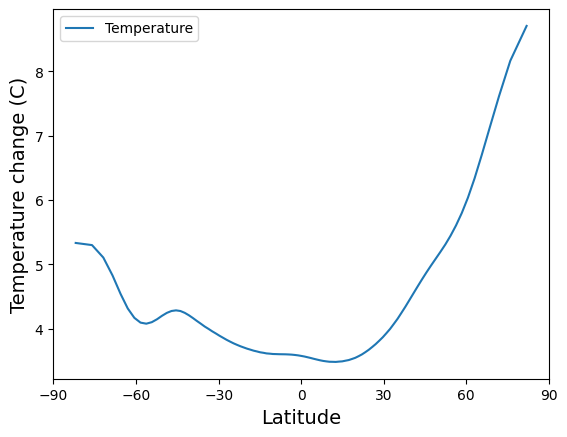

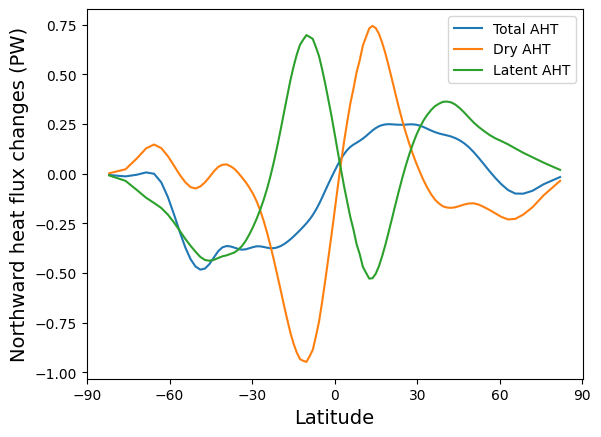

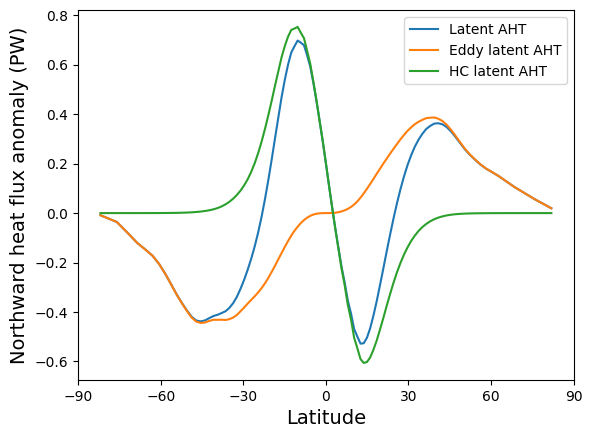

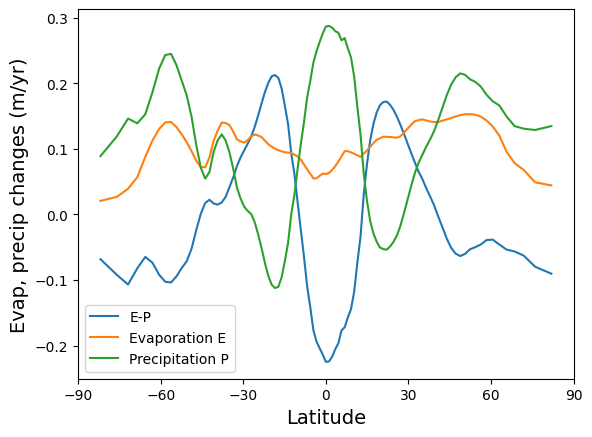

In [428]:
# Figures for perturbation (changes under 4xCO2, relative to climatology values above) 

plt.plot(phi,T)
plt.legend(["Temperature"])
plt.xticks(np.arange(-90, 91, 30))
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Temperature change (C)', fontsize=14)
plt.show()

plt.plot(phi,(F_expt-F_ctrl)/10**15) #total heat transport
plt.plot(phi,((F_expt-F_LH_expt) - (F_ctrl-F_LH_ctrl))/10**15) #dry
plt.plot(phi,(F_LH_expt - F_LH_ctrl)/10**15) #latent
plt.legend(["Total AHT", "Dry AHT", "Latent AHT"])
plt.xticks(np.arange(-90, 91, 30))
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Northward heat flux changes (PW)', fontsize=14)
plt.show()

plt.plot(phi,(F_LH_expt - F_LH_ctrl)/10**15) #latent heat transport
plt.plot(phi,(F_LH_eddy_expt - F_LH_eddy_ctrl)/10**15) #eddy component of latent
plt.plot(phi,(-L*V_expt*q_expt - (-L*V_ctrl*q_ctrl))/10**15) #Hadley cell component of latent 
plt.legend(["Latent AHT", "Eddy latent AHT", "HC latent AHT"])
plt.xticks(np.arange(-90, 91, 30))
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Northward heat flux anomaly (PW)', fontsize=14)
plt.show()

plt.plot(phi,E_m_P_expt - E_m_P_ctrl) #Evaporation minus precipitation (E-P) changes in m/yr
plt.plot(phi,(E_expt - E_ctrl)/(L*rho)*np.pi*1e7) #E changes in m/yr
plt.plot(phi,(P_expt - P_ctrl)/(L*rho)*np.pi*1e7) #P changes in m/yr
plt.legend(["E-P", "Evaporation E", "Precipitation P"])
plt.xticks(np.arange(-90, 91, 30))
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Evap, precip changes (m/yr)', fontsize=14)
plt.show()